In [1]:
import numpy as np
import netCDF4 as nc
from tqdm import tqdm
import os

In [2]:
## 8Km by 8 Km by 20m grid
cube = nc.Dataset('/data/SO2/SO24/ANDY/SOHI/Data/Obs_Climatology/ISMIP6/obs_temperature_1995-2017_8km_x_60m.nc')
LONS = cube['lon'][:]
LATS = cube['lat'][:]
DEPTHS = np.arange(-10, -3000, -20)

# Create Maping indices

### SOHI

In [9]:
## SOHI 
cube = nc.Dataset('/data/SO2/SO24/ANDY/SOHI/Data/Models/SOHI/Monthly_Mean/2005_12.nc')
XC = cube['lon'][:]
YC = cube['lat'][:]
RC = cube['depth'][:]

In [17]:
indices = [[],[]]

for i in tqdm(range(LONS.shape[0])):
    for j in range(LONS.shape[1]):
        indices[1].append(np.argmin(abs(XC - LONS[i,j])))
        indices[0].append(np.argmin(abs(YC - LATS[i,j])))
indices = np.asarray(indices)

np.save('map_index/SOHI.npy', indices)

100%|█████████████████████████████████████████| 761/761 [01:34<00:00,  8.08it/s]


### SOSE

In [30]:
## SOSE 
cube = nc.Dataset('/data/SO2/SO24/ANDY/SOHI/Data/Models/SOSE/SOSE_iter100.nc')
XC = cube['lon'][:]
YC = cube['lat'][:]
RC = cube['depth'][:]

In [32]:
indices = [[],[]]

for i in tqdm(range(LONS.shape[0])):
    for j in range(LONS.shape[1]):
        indices[1].append(np.argmin(abs(XC - LONS[i,j])))
        indices[0].append(np.argmin(abs(YC - LATS[i,j])))
indices = np.asarray(indices)

np.save('map_index/SOSE.npy', indices)

100%|█████████████████████████████████████████| 761/761 [01:15<00:00, 10.04it/s]


### LLC4320

In [33]:
## LLC4320
XC = np.load("/data/SO2/SO24/ANDY/SOHI/Data/Models/LLC4320/meta/XC.npy")
XC=XC[:-1,:]
YC = np.load("/data/SO2/SO24/ANDY/SOHI/Data/Models/LLC4320/meta/YC.npy")
YC=YC[:-1,:]

In [34]:
import dask
from dask.diagnostics import ProgressBar

In [35]:
ProgressBar().register()

In [36]:
@dask.delayed(nout=2)
def find(YC, XC, lat, lon):
    i1 = (XC - lon)**2
    i2 = (YC - lat)**2
    try:
        i3 = i1 + i2
    except:
        print(lat, lon, i1.shape, i2.shape)
        raise ValueError()
    where = np.where(i3 == i3.min())
    return where[0][0], where[1][0] ## Return row, column

In [37]:
indices=[[],[]]

for i in tqdm(range(LONS.shape[0])):
    for j in range(LONS.shape[1]):
        idy, idx = find(YC, XC, LATS[i,j], LONS[i,j])
        indices[0].append(idy)
        indices[1].append(idx)
        
idy = dask.compute(indices[0])
idx = dask.compute(indices[1])

indices = np.asarray([idy, idx])
np.save('map_index/LLC4320.npy', indices)

100%|█████████████████████████████████████████| 761/761 [01:23<00:00,  9.12it/s]


[########################################] | 100% Completed |  5hr 48min 32.8s
[########################################] | 100% Completed |  4hr 29min 22.6s


### LLC90

In [40]:
## ECCO 
cube = nc.Dataset("/data/SO2/SO24/ANDY/SOHI/Data/Models/ECCO/LLC90_v4r4.nc")
XC = cube['lon'][:]
YC = cube['lat'][:]
RC = cube['depth'][:]

In [41]:
indices=[[],[]]

for i in tqdm(range(LONS.shape[0])):
    for j in range(LONS.shape[1]):
        idy, idx = find(YC, XC, LATS[i,j], LONS[i,j])
        indices[0].append(idy)
        indices[1].append(idx)
        
idy = dask.compute(indices[0])
idx = dask.compute(indices[1])

indices = np.asarray([idy, idx])
np.save('map_index/LLC90.npy', indices)

100%|█████████████████████████████████████████| 761/761 [01:06<00:00, 11.51it/s]


[########################################] | 100% Completed |  8min 58.8s
[########################################] | 100% Completed |  8min 53.2s


# Map Models

In [7]:
def sample(og, og_RC, ref_RC, idy, idx, n=2):
    data = np.zeros((150,761,761))
    
    zdim = data.shape[0]
    ydim = data.shape[1]
    xdim = data.shape[2]
    
    count = 0
    for i in tqdm(range(761)):
        for j in range(761):
            iy = idy[count]
            ix = idx[count]
            count += 1
            
            min_x = np.max([0, ix-n])
            max_x = np.min([xdim, ix+n])

            min_y = np.max([0, iy-n])
            max_y = np.min([ydim, iy+n])
            
            for z in range(len(ref_RC)):
                iz = np.argmin(abs(ref_RC[z] - og_RC))
                data[z, i, j] = np.nanmean(og[iz, min_y:max_y, min_x, max_x])
                
    return data

# SOHI

In [6]:
## SOHI 
directory = '/data/SO2/SO24/ANDY/SOHI/Data/Models/SOHI/Monthly_Mean'
fn = ['2005_10','2005_11','2005_12','2006_01','2006_02', '2006_03', '2006_04','2006_05','2006_06',
     '2006_07','2006_08','2006_09']
indices = np.load('data_indices/SOHI.npy')
idy = indices[0]
idx = indices[1]

## THETA
cube = nc.Dataset(f"{directory}/{fn[0]}.nc")
data = cube['THETA'][0,:,:,:]

for f in tqdm(range(1,len(fn))):
    cube = nc.Dataset(f"{directory}/{fn[f]}.nc")
    data = data + cube['THETA'][0,:,:,:]
    
data = data/12

nf = mapp(og = data,
             og_RC = cube['depth'][:],
             ref_RC = DEPTHS,
             idy = idy,
             idx = idx,
             n = 2)

np.save(f'maps/SOHI_T.npy', nf)
    
## SALT
cube = nc.Dataset(f"{directory}/{fn[f]}.nc")
data = cube['SALT'][0,:,:,:]

for f in tqdm(range(1,len(fn))):
    cube = nc.Dataset(f"{directory}/{fn[f]}.nc")
    data = data + cube['SALT'][0,:,:,:]
    
data = data/12

nf = mapp(og = data,
             og_RC = cube['depth'][:],
             ref_RC = DEPTHS,
             idy = idy,
             idx = idx)

np.save(f'maps/SOHI_S.npy', nf)

  0%|                                                     | 0/761 [00:00<?, ?it/s]/tmp/ipykernel_613391/3323079040.py:11: UserWarning: Warning: converting a masked element to nan.
  data[z, i, j] = og[iz, iy, ix]
100%|███████████████████████████████████████████| 761/761 [19:33<00:00,  1.54s/it]


In [8]:
import h5py

import sys
sys.path.insert(0,'/data/SO2/SO24/ANDY/SOHI/scripts')
import data_paths
import gc

In [9]:
del data
gc.collect()

217

# LLC4320

In [17]:
directory = '/data/SO2/SO24/ANDY/SOHI/Data/Models/LLC4320/Monthly_Mean'
fn = ['2011_10', '2011_11', '2011_12', '2012_01', '2012_02', '2012_03', '2012_04', '2012_05', '2012_06',
     '2012_07', '2012_08', '2012_09']
indices = np.load('data_indices/LLC4320.npy')
idy = indices[0][0]
idx = indices[1][0]

## THETA
cube = nc.Dataset(f"{directory}/{fn[0]}.nc")
data = cube['Theta'][:,:,:]

for f in tqdm(range(1,len(fn))):
    cube = nc.Dataset(f"{directory}/{fn[f]}.nc")
    data = data + cube['Theta'][:,:,:]
    
data = data/12

nf = mapp(og = data,
             og_RC = cube['depth'][:],
             ref_RC = DEPTHS,
             idy = idy,
             idx = idx)

np.save(f'maps/LLC_T.npy', nf)
    
## SALT
cube = nc.Dataset(f"{directory}/{fn[f]}.nc")
data = cube['Salt'][:,:,:]

for f in tqdm(range(1,len(fn))):
    cube = nc.Dataset(f"{directory}/{fn[f]}.nc")
    data = data + cube['Salt'][:,:,:]
    
data = data/12

nf = mapp(og = data,
             og_RC = cube['depth'][:],
             ref_RC = DEPTHS,
             idy = idy,
             idx = idx)

np.save(f'maps/LLC_S.npy', nf)

  0%|                                                     | 0/761 [00:00<?, ?it/s]/tmp/ipykernel_613391/3323079040.py:11: UserWarning: Warning: converting a masked element to nan.
  data[z, i, j] = og[iz, iy, ix]
100%|███████████████████████████████████████████| 761/761 [19:16<00:00,  1.52s/it]


# SOSE

In [18]:
cube = nc.Dataset('/data/SO2/SO24/ANDY/SOHI/Data/Models/SOSE/SOSE_iter100.nc')
RC = cube['depth'][:]
indices = np.load('data_indices/SOSE.npy')
idy = indices[0]
idx = indices[1]

tindex = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
fn = ['2005_09','2005_10','2005_11','2005_12','2006_01','2006_02','2006_03','2006_04','2006_05',
     '2006_06','2006_07','2006_08']

## THETA
data = cube['THETA'][tindex[0],:,:,:]

for f in tqdm(range(1,len(tindex))):
    data = data + cube['THETA'][tindex[f],:,:,:]
    
data = data/12

nf = mapp(og = data,
             og_RC = cube['depth'][:],
             ref_RC = DEPTHS,
             idy = idy,
             idx = idx)

np.save(f'maps/SOSE_T.npy', nf)
    
## SALT
data = cube['SALT'][tindex[0],:,:,:]

for f in tqdm(range(1,len(tindex))):
    data = data + cube['SALT'][tindex[f],:,:,:]
    
data = data/12

nf = mapp(og = data,
             og_RC = cube['depth'][:],
             ref_RC = DEPTHS,
             idy = idy,
             idx = idx)

np.save(f'maps/SOSE_S.npy', nf)

  1%|▍                                            | 7/761 [00:10<17:50,  1.42s/it]/tmp/ipykernel_613391/3323079040.py:11: UserWarning: Warning: converting a masked element to nan.
  data[z, i, j] = og[iz, iy, ix]
100%|███████████████████████████████████████████| 761/761 [18:31<00:00,  1.46s/it]


# LLC90

In [ ]:
cube = nc.Dataset('/data/SO2/SO24/ANDY/SOHI/Data/Models/ECCO/LLC90_v4r4.nc')
indices = np.load('data_indices/LLC90.npy')
idy = indices[0][0]
idx = indices[1][0]

tindex = [165, 166, 167, 168, 169, 170, 171, 172, 183, 174, 175, 176]
fn = ['2005_10','2005_11','2005_12','2006_01','2006_02','2006_03','2006_04','2006_05','2006_06',
      '2006_07','2006_08', '2006_09']

## THETA
data = cube['THETA'][tindex[0],:,:,:]

for f in tqdm(range(1,len(tindex))):
    data = data + cube['THETA'][tindex[f],:,:,:]
    
data = data/12

nf = mapp(og = data,
             og_RC = cube['depth'][:],
             ref_RC = DEPTHS,
             idy = idy,
             idx = idx)

np.save(f'maps/ECCO_T.npy', nf)
    
## SALT
data = cube['SALT'][tindex[0],:,:,:]

for f in tqdm(range(1,len(tindex))):
    data = data + cube['SALT'][tindex[f],:,:,:]
    
data = data/12

nf = mapp(og = data,
             og_RC = cube['depth'][:],
             ref_RC = DEPTHS,
             idy = idy,
             idx = idx)

np.save(f'maps/ECCO_S.npy', nf)

  9%|███▉                                        | 68/761 [01:37<16:36,  1.44s/it]/tmp/ipykernel_613391/3323079040.py:11: UserWarning: Warning: converting a masked element to nan.
  data[z, i, j] = og[iz, iy, ix]
 64%|███████████████████████████▋               | 490/761 [11:57<06:39,  1.48s/it]

### Region_Mask

In [3]:
def mapp2D(og, idy, idx):
    data = np.zeros((761,761))
    count = 0
    for i in tqdm(range(761)):
        for j in range(761):
            iy = idy[count]
            ix = idx[count]
            

            data[i, j] = og[iy, ix]
                
            count += 1
    return data

In [13]:
indices.shape

(2, 1, 579121)

In [25]:
mask = np.load('/data/SO2/SO24/ANDY/SOHI/Notebooks/1_SOHI_Eval/99_HeatTransport_Eval/data_stair_stepping/ECCO_mask.npy')
indices = np.load('map_index/LLC90.npy')

idy = indices[0,0]
idx = indices[1,0]


new_mask = np.zeros((761,761))
count = 0
for i in tqdm(range(761)):
    for j in range(761):
        iy = idy[count]
        ix = idx[count]
            

        new_mask[i, j] = mask[iy, ix]
                
        count += 1
    

100%|███████████████████████████████████████████████████████| 761/761 [00:00<00:00, 2048.67it/s]


In [26]:
import matplotlib.pyplot as plt

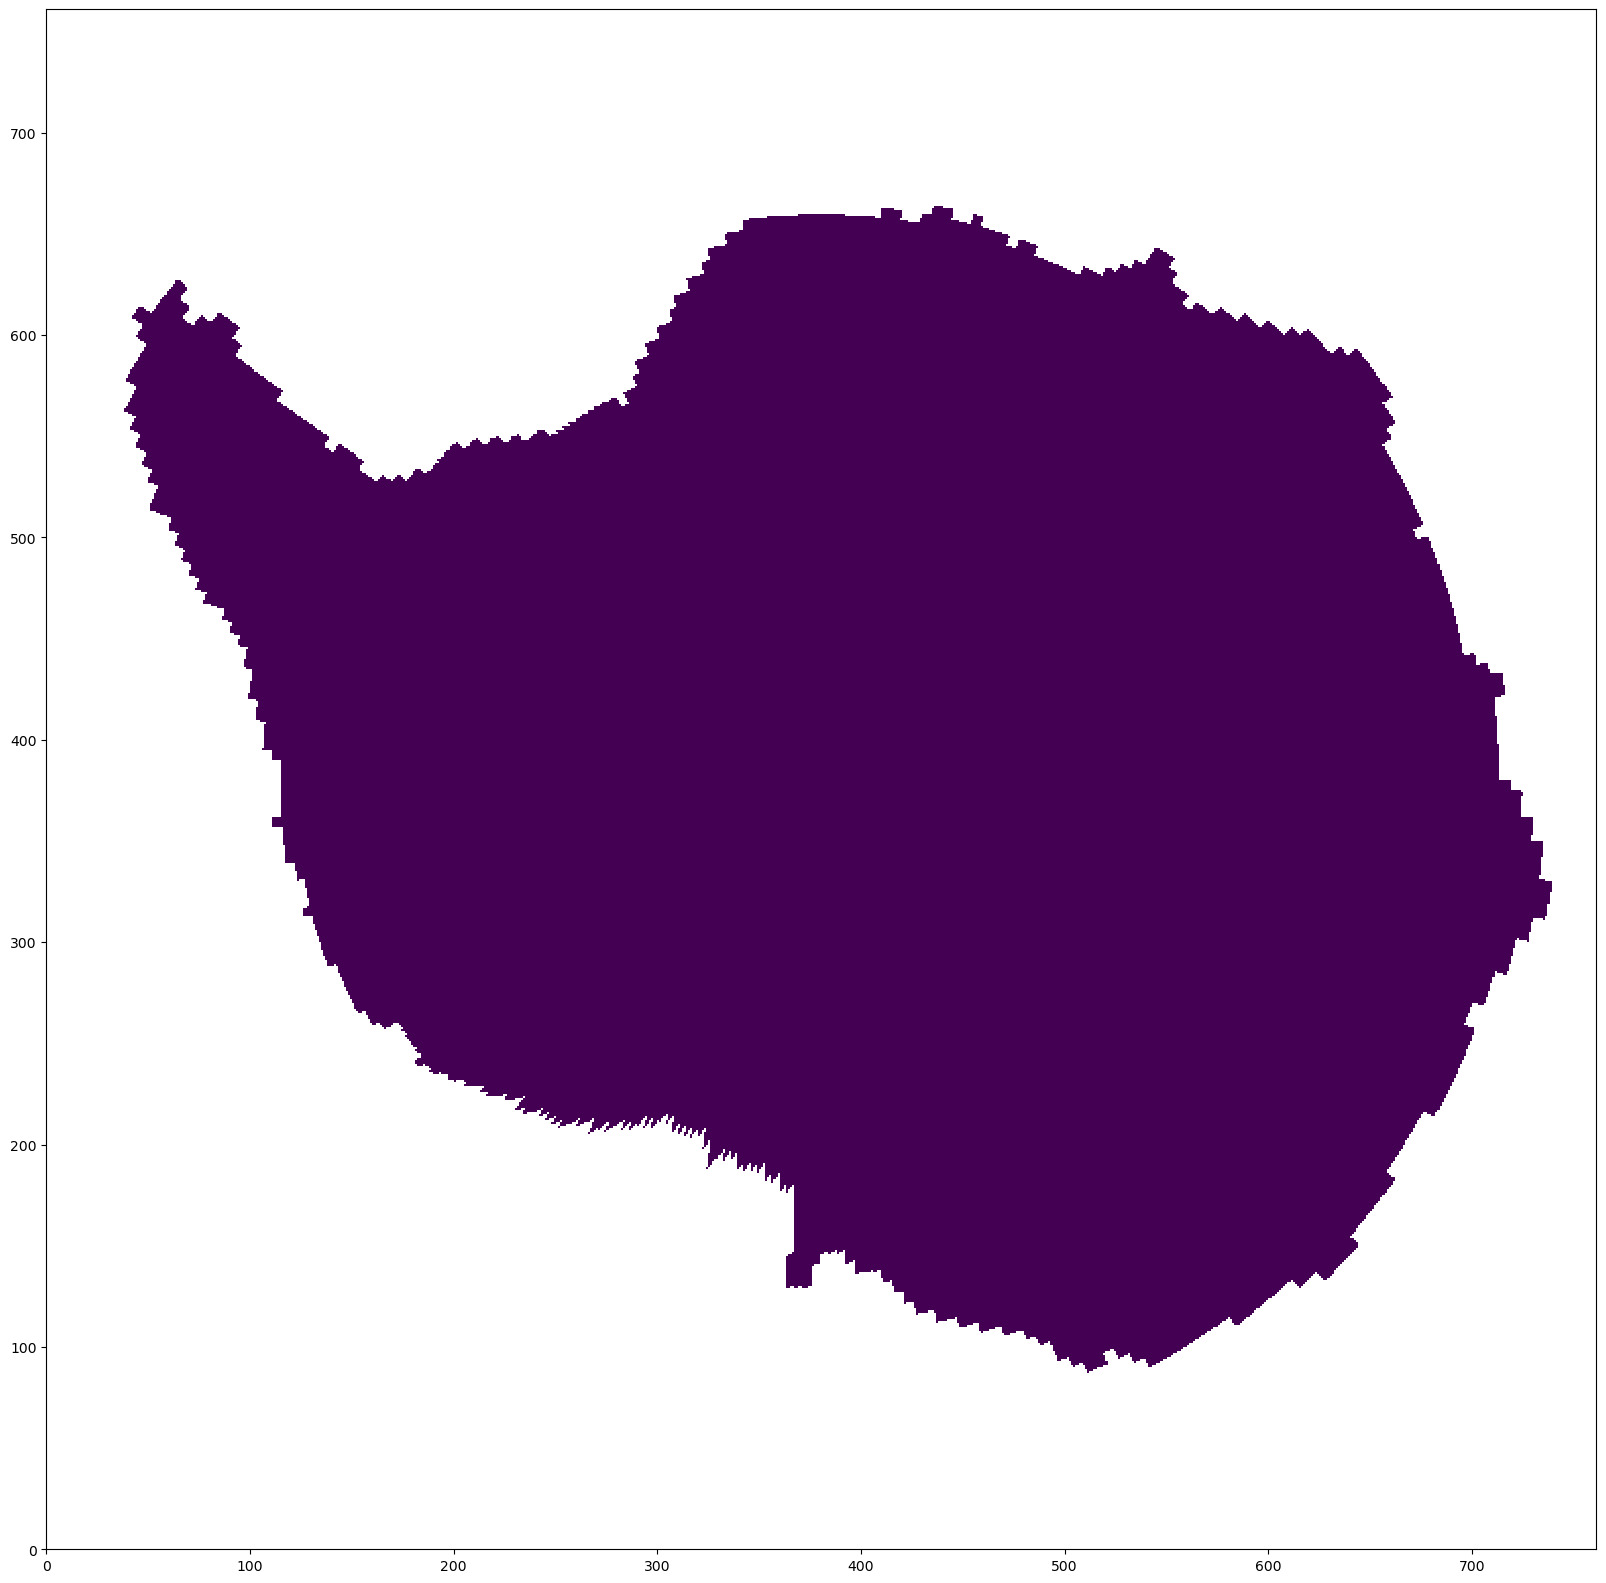

In [27]:
fig, ax = plt.subplots(figsize=(20,20))
ax.pcolormesh(new_mask)

In [28]:
np.save("ECCO_mask.npy", new_mask)

In [12]:
import h5py

In [24]:
np.nanmin(IS)

-3001.999755859375

In [25]:
bath = h5py.File(data_paths.grid)
bath = -bath['Depth'][:2344, :]

IS = h5py.File('/data/SO2/SO24/ANDY/SOHI/Data/Models/SOHI/meta/ICEDRAFT_v8.mat')
IS = IS['Ice_Map'][:2344, :]

bath = bath + IS

indices = np.load('data_indices/SOHI.npy')
idy = indices[0]
idx = indices[1]

# bath = - np.load("/data/SO2/SO24/ANDY/SOHI/Data/Models/LLC4320/meta/bathymetry.npy")
# indices = np.load('data_indices/LLC4320.npy')
# idy = indices[0][0]
# idx = indices[1][0]

# bath = np.load('/data/SO2/SO24/ANDY/SOHI/Data/Models/SOSE/Bathymetry.npy')
# indices = np.load('data_indices/SOSE.npy')
# idy = indices[0]
# idx = indices[1]

# bath = np.load("/data/SO2/SO24/ANDY/SOHI/Data/Models/ECCO/LLC90_bath.npy")
# indices = np.load('data_indices/LLC90.npy')
# idy = indices[0][0]
# idx = indices[1][0]

# IS = h5py.File('/data/SO2/SO24/ANDY/SOHI/Data/Models/SOHI/meta/ICEDRAFT_v8.mat')
# IS = IS['Ice_Map'][:]
# IS[IS != 0] = 1
# indices = np.load('data_indices/SOHI.npy')
# idy = indices[0]
# idx = indices[1]

In [26]:
new_bath = mapp2D(og = bath,
             idy = idy,
             idx = idx)

100%|█████████████████████████████████████████| 761/761 [00:00<00:00, 2052.33it/s]


In [27]:
np.save(f'maps/SOHI_Bathymetry.npy', new_bath)